# CH6 AnoGAN, Efficient GAN

In [112]:
import os.path as osp
import random
# 파일이나 텍스트에서 XML을 읽고, 가공하고 저장하기 위한 라이브러리s
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
import torch.nn as nn
import json
import time
import torch.nn.functional as F

%matplotlib inline

In [113]:
cd /content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/6_gan_anomaly_detection

/content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/6_gan_anomaly_detection


## CH6.2 AnoGAN 구현 및 이상 탐지 실시

### CH6.2.1 DCGAN학습

In [98]:
from torchvision import transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def make_test_datapath_list():
  """학습 및 검증 화상 데이터와 어노테이션 데이터의 파일 경로 리스트 작성"""
  train_img_list = list()

  for img_idx in range(5):
    img_path = "./data/test/img_7_" + str(img_idx) + '.jpg'
    train_img_list.append(img_path)
    img_path = "./data/test/img_8_" + str(img_idx) + '.jpg'
    train_img_list.append(img_path)
    img_path = "./data/test/img_2_" + str(img_idx) + '.jpg'
    train_img_list.append(img_path)
  return train_img_list

def make_train_datapath_list():
  """학습 및 검증 화상 데이터와 어노테이션 데이터의 파일 경로 리스트 작성"""
  train_img_list = list()

  for img_idx in range(200):
    img_path = "./data/img_78/img_7_" + str(img_idx) + '.jpg'
    train_img_list.append(img_path)
    img_path = "./data/img_78/img_8_" + str(img_idx) + '.jpg'
    train_img_list.append(img_path)
  return train_img_list

class GAN_Img_Dataset(data.Dataset):
    """화상의 Dataset 클래스. PyTorch의 Dataset 클래스를 상속"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''화상 매수를 반환한다'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''전처리한 화상의 Tensor 형식 데이터 취득'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [높이][폭]흑백

        # 화상 전처리
        img_transformed = self.transform(img)

        return img_transformed

class ImageTransform():
    """화상의 전처리 클래스"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

test_img_list = make_test_datapath_list()
train_img_list = make_train_datapath_list()

mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(file_list = test_img_list, transform = ImageTransform(mean,std))
train_dataset = GAN_Img_Dataset(file_list = train_img_list, transform = ImageTransform(mean,std))

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = False)

In [99]:
class Generator(nn.Module):
  def __init__(self, z_dim = 20, image_size = 64):
    super(Generator, self).__init__()

    self.layer1 = nn.Sequential(
                                 nn.ConvTranspose2d(z_dim, image_size * 8, kernel_size= 4, stride = 1),
                                 nn.BatchNorm2d(image_size * 8),
                                 nn.ReLU(inplace = True)
    )

    self.layer2 = nn.Sequential(
                                 nn.ConvTranspose2d(image_size*8, image_size * 4, kernel_size = 4, stride = 2, padding = 1),
                                 nn.BatchNorm2d(image_size * 4),
                                 nn.ReLU(inplace = True)
    )

    self.layer3 = nn.Sequential(
                                 nn.ConvTranspose2d(image_size*4, image_size * 2, kernel_size = 4, stride = 2, padding = 1),
                                 nn.BatchNorm2d(image_size * 2),
                                 nn.ReLU(inplace = True)
    )

    self.layer4 = nn.Sequential(
                                 nn.ConvTranspose2d(image_size*2, image_size * 1, kernel_size = 4, stride = 2, padding = 1),
                                 nn.BatchNorm2d(image_size * 1),
                                 nn.ReLU(inplace = True)
    )

    self.last = nn.Sequential(nn.ConvTranspose2d(image_size, 1 ,kernel_size = 4, stride =2 , padding = 1),
                              nn.Tanh())

  def forward(self,x):
    return self.last(self.layer4(self.layer3(self.layer2(self.layer1(x)))))

class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 주의: 흑백 화상이므로 입력 채널은 하나 뿐임

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        feature = out  # 최후에 채널을 하나로 집약
        feature = feature.view(feature.size()[0], -1)  # 2차원으로 변환

        out = self.last(out)

        return out, feature

In [100]:
# 동작 확인
D = Discriminator(z_dim=20, image_size=64)

# 가짜 화상 생성
input_z = torch.randn(1, 20).to(device)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
fake_images = fake_images.to('cpu')

# 가짜 화상을 D에 입력
d_out = D(fake_images)

# 출력 d_out에 Sigmoid를 곱해 0에서 1로 변환
print(nn.Sigmoid()(d_out[0]))

# feature
print(d_out[1].shape)

tensor([[[[0.5002]]]], grad_fn=<SigmoidBackward0>)
torch.Size([1, 8192])


In [101]:
# 네트워크 초기화
G = Generator(z_dim=20, image_size=64)
D = Discriminator(z_dim=20, image_size=64)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2dとConvTranspose2d 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2d 초기화
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# 초기화 실시
G.apply(fn = weights_init)
D.apply(fn = weights_init)

print("네트워크 초기화 완료")

네트워크 초기화 완료


In [102]:
# 모델을 학습시키는 함수를 작성
def train_model(G, D, dataloader, num_epochs):

    # GPU가 사용 가능한지 확인
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용 장치: ", device)

    # 최적화 기법 설정
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 오차함수 정의
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # 파라미터를 하드코딩
    z_dim = 20
    mini_batch_size = 64

    # 네트워크를 GPU로
    G.to(device)
    D.to(device)

    G.train()  # 모델을 훈련 모드로
    D.train()  # 모델을 훈련 모드로

    # 네트워크가 어느 정도 고정되면, 고속화시킨다
    torch.backends.cudnn.benchmark = True

    # 화상의 매수
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # 반복 카운터 설정
    iteration = 1
    logs = []

    # epoch 루프
    for epoch in range(num_epochs):

        # 개시 시간을 저장
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epoch의 손실합
        epoch_d_loss = 0.0  # epoch의 손실합

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('(train)')

        # 데이터 로더에서 minibatch씩 꺼내는 루프
        for imges in dataloader:

            # --------------------
            # 1. Discriminator 학습
            # --------------------
            # 미니 배치 크기가 1이면, 배치 노멀라이제이션에서 에러가 발생하므로 피한다
            if imges.size()[0] == 1:
                continue

            # GPU가 사용 가능하면 GPU로 데이터를 보낸다
            imges = imges.to(device)

            # 정답 라벨과 가짜 라벨 작성
            # epoch의 마지막 반복은 미니 배치 수가 줄어든다
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1.).to(device)
            label_fake = torch.full((mini_batch_size,), 0.).to(device)

            # 진짜 화상을 판정
            d_out_real, _ = D(imges)

            # 가짜 화상을 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images)

            # 오차를 계산
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generator 학습
            # --------------------
            # 가짜 화상을 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images)

            # 오차를 계산
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 기록
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epoch의 phase별 loss와 정답률
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    
    print("총 반복 횟수: ", iteration)

    return G, D

In [103]:
num_epochs = 300
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs)

사용 장치:  cuda:0
-------------
Epoch 0/300
-------------
(train)
-------------
epoch 0 || Epoch_D_Loss:0.0878 ||Epoch_G_Loss:0.1929
timer:  6.3601 sec.
-------------
Epoch 1/300
-------------
(train)
-------------
epoch 1 || Epoch_D_Loss:0.0060 ||Epoch_G_Loss:0.4732
timer:  0.9029 sec.
-------------
Epoch 2/300
-------------
(train)
-------------
epoch 2 || Epoch_D_Loss:0.0014 ||Epoch_G_Loss:0.5961
timer:  1.1268 sec.
-------------
Epoch 3/300
-------------
(train)
-------------
epoch 3 || Epoch_D_Loss:0.0002 ||Epoch_G_Loss:0.7336
timer:  0.9059 sec.
-------------
Epoch 4/300
-------------
(train)
-------------
epoch 4 || Epoch_D_Loss:0.1341 ||Epoch_G_Loss:0.4159
timer:  0.9091 sec.
-------------
Epoch 5/300
-------------
(train)
-------------
epoch 5 || Epoch_D_Loss:0.0009 ||Epoch_G_Loss:0.6449
timer:  0.8922 sec.
-------------
Epoch 6/300
-------------
(train)
-------------
epoch 6 || Epoch_D_Loss:0.3155 ||Epoch_G_Loss:0.2440
timer:  0.9122 sec.
-------------
Epoch 7/300
-------------


tensor([[[[0.3969]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
torch.Size([1, 8192])


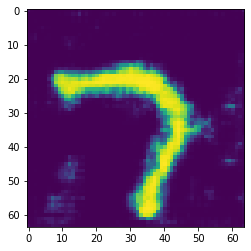

In [105]:
# 가짜 화상 생성
input_z = torch.randn(1, 20).to(device)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G_update(input_z)

# 가짜 화상을 D에 입력
d_out = D_update(fake_images)

# 출력 d_out에 Sigmoid를 곱해 0에서 1로 변환
print(nn.Sigmoid()(d_out[0]))

# feature
print(d_out[1].shape)
plt.imshow(fake_images.cpu().detach()[0][0])
plt.show()

### CH6.2.3 AnoGAN의 손실함수

In [106]:
def Anomaly_score(x, fake_img, D, Lambda = 0.1):
  # 테스트할 입력 이미지 데이터 x와 G가 생성한 이미지와의 차이를 계산한다.
  # 미니 배치마다 합을 구한다.
  residual_loss = torch.abs(x-fake_img)
  residual_loss = residual_loss.view(residual_loss.size()[0], -1) # 2차원으로 변형
  residual_loss = torch.sum(residual_loss, dim = 1)

  # 테스트할 입력 이미지 데이터 x와 생성된 화상 fake_img를 식별기 D에 입력하여 특징량 맵을 꺼낸다.
  _, x_feature = D(x)
  _, G_feature = D(fake_img)

  # 테스트 이미지 x와 생성 fake_img의 특징량 차이의 절대값을 계산하여 미니배치마다 합을 구한다.
  discrimination_loss = torch.abs(x_feature - G_feature)
  discrimination_loss = discrimination_loss.view(discrimination_loss.size()[0], -1)
  discrimination_loss = torch.sum(discrimination_loss, dim = 1)

  # 미니 배치 별로 손실을 더한다.
  loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss

  # 모든 미니 배치의 손실을 구한다
  total_loss = torch.sum(loss_each)
  
  return total_loss, loss_each, residual_loss

### CH6.2.4 AnoGAN 학습 구현과 이상 탐지 실시

In [107]:
from torchvision import transforms
def make_test_datapath_list():
  """학습 및 검증 화상 데이터와 어노테이션 데이터의 파일 경로 리스트 작성"""
  train_img_list = list()

  for img_idx in range(5):
    img_path = "./data/test/img_7_" + str(img_idx) + '.jpg'
    train_img_list.append(img_path)
    img_path = "./data/test/img_8_" + str(img_idx) + '.jpg'
    train_img_list.append(img_path)
    img_path = "./data/test/img_2_" + str(img_idx) + '.jpg'
    train_img_list.append(img_path)
  return train_img_list

def make_train_datapath_list():
  """학습 및 검증 화상 데이터와 어노테이션 데이터의 파일 경로 리스트 작성"""
  train_img_list = list()

  for img_idx in range(5):
    img_path = "./data/test/img_7_" + str(img_idx) + '.jpg'
    train_img_list.append(img_path)
    img_path = "./data/test/img_8_" + str(img_idx) + '.jpg'
    train_img_list.append(img_path)
  return train_img_list

class GAN_Img_Dataset(data.Dataset):
    """화상의 Dataset 클래스. PyTorch의 Dataset 클래스를 상속"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''화상 매수를 반환한다'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''전처리한 화상의 Tensor 형식 데이터 취득'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [높이][폭]흑백

        # 화상 전처리
        img_transformed = self.transform(img)

        return img_transformed

class ImageTransform():
    """화상의 전처리 클래스"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

test_img_list = make_test_datapath_list()
train_img_list = make_train_datapath_list()

mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(file_list = test_img_list, transform = ImageTransform(mean,std))
train_dataset = GAN_Img_Dataset(file_list = train_img_list, transform = ImageTransform(mean,std))

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = False)

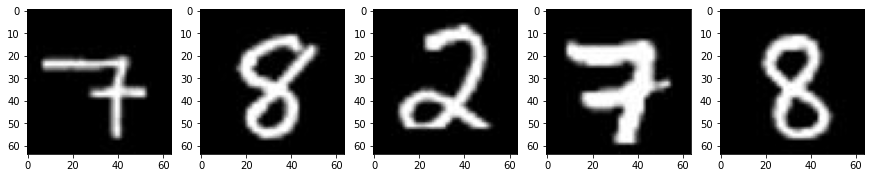

In [108]:
fig = plt.figure(figsize = (15,6))
iterator = iter(test_dataloader)
imges = next(iterator)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

In [110]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
x = imges[:5]
x = x.to(device)
z = torch.randn(5,20).to(device)
z = z.view(z.size(0),z.size(1), 1, 1)
z.requires_grad = True # grad 계산이 가능하게 해 준다.
z_optimizer = torch.optim.Adam([z], lr = 1e-3) # z 가 loss 에 끼치는 영향을 알고 싶다.

for epoch in range(5000+1):
  fake_img = G_update(z)
  loss, _, _ = Anomaly_score(x, fake_img, D_update, Lambda = 0.1)

  z_optimizer.zero_grad()
  loss.backward()
  z_optimizer.step()

  if epoch%1000 == 0:
    print('epoch {} || loss_total : {}'.format(epoch, loss.item()))

epoch 0 || loss_total : 6398.55029296875
epoch 1000 || loss_total : 4469.60205078125
epoch 2000 || loss_total : 3362.143798828125
epoch 3000 || loss_total : 2820.697265625
epoch 4000 || loss_total : 2253.4423828125
epoch 5000 || loss_total : 2210.20703125


total loss:  [352. 310. 745. 481. 324.]


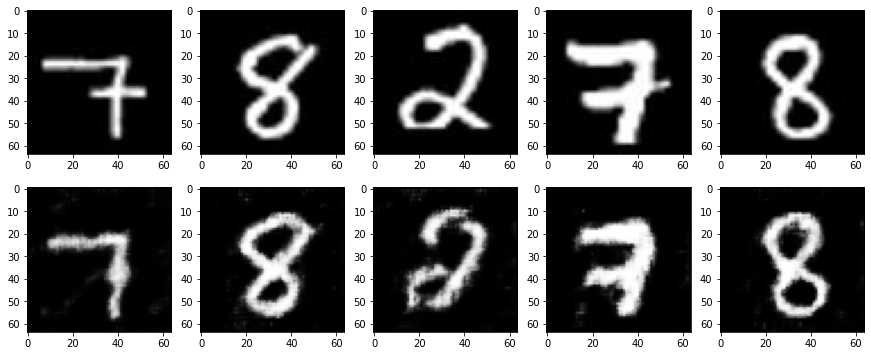

In [111]:
# 화상 생성
G_update.eval()
fake_img = G_update(z)

# 손실을 구한다
loss, loss_each, residual_loss_each = Anomaly_score(
    x, fake_img, D_update, Lambda=0.1)

# 손실 계산. 총 손실
loss_each = loss_each.cpu().detach().numpy()
print("total loss: ", np.round(loss_each, 0))

# 화상을 시각화
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 상단에 테스트 데이터를,
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 하단에 생성 데이터를 표시한다
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_img[i][0].cpu().detach().numpy(), 'gray')

##CH6.3 Efficient GAN의 개요

### CH6.3.3 인코더 E를 GAN과 동시에 만드는 방법

## CH6.4 Efficient GAN 구현 및 이상 탐지

### CH6.4.1 Generator와 Discriminator 구현

In [171]:
class Generator(nn.Module):

  def __init__(self, z_dim = 20) :
    super(Generator, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Linear(z_dim, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(inplace = True)
    )

    self.layer2 = nn.Sequential(
        nn.Linear(1024, 7*7*128),
        nn.BatchNorm1d(7*7*128),
        nn.ReLU(inplace = True)
    )

    self.layer3 = nn.Sequential(
        nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 4, stride = 2, padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace = True)
    )

    self.last = nn.Sequential(
        nn.ConvTranspose2d(in_channels = 64, out_channels = 1, kernel_size = 4, stride = 2, padding = 1),
        nn.Tanh()
    )

  def forward(self,z):
    out = self.layer1(z)
    out = self.layer2(out)
    out = out.view(z.shape[0], 128, 7, 7)
    out = self.layer3(out)
    out = self.last(out)

    return out


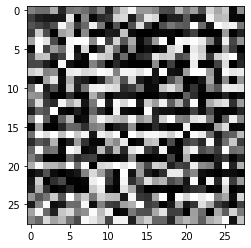

In [172]:
G = Generator()
G.train()
input_z = torch.randn(2,20)

fake_images = G(input_z)
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

In [173]:
class Discriminator(nn.Module):
  def __init__(self,z_dim=20):
    super(Discriminator, self).__init__()

    self.x_layer1 = nn.Sequential(
        nn.Conv2d(1,64, kernel_size = 4, stride = 2, padding = 1),
        nn.LeakyReLU(0.1, inplace = True))

    self.x_layer2 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size = 4, stride = 2, padding = 1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.1, inplace = True)
    )  

    self.z_layer1 = nn.Linear(z_dim,512) #z 입력

    self.last1 = nn.Sequential(
        nn.Linear(3648, 1024),
        nn.LeakyReLU(0.1, inplace = True)
    )

    self.last2 = nn.Sequential(
        nn.Linear(1024, 1)
    )

  def forward(self, x, z):
    x_out = self.x_layer1(x)
    x_out = self.x_layer2(x_out)

    z = z.view(z.shape[0], -1 )# 2차원 변환
    z_out = self.z_layer1(z)

    x_out = x_out.view(-1, 64*7*7)
    out = torch.cat([x_out, z_out], axis = 1)
    out = self.last1(out)
    feature = out
    feature = feature.view(feature.size()[0], -1 )
    out = self.last2(out)
    return out, feature


In [174]:
D = Discriminator()
input_z = torch.randn(2,20)
fake_images = G(input_z)

d_out ,_ = D(fake_images, input_z)
print(nn.Sigmoid()(d_out))

tensor([[0.4937],
        [0.4502]], grad_fn=<SigmoidBackward0>)


In [175]:
fake_images.size()

torch.Size([2, 1, 28, 28])

### CH6.4.2 인코더 구현

In [176]:
class Encoder(nn.Module):
  def __init__(self, z_dim = 20):
    super(Encoder, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(1,32,kernel_size = 3, stride = 1),
        nn.LeakyReLU(0.1, inplace = True)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(32,64, kernel_size = 3 , stride = 2, padding = 1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.1, inplace = True)
    )

    self.layer3 = nn.Sequential(
        nn.Conv2d(64,128,kernel_size = 3, stride = 2, padding = 1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.1, inplace = True)
    )

    self.last = nn.Linear(128*7*7, z_dim)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = out.view(-1, 128*7*7)
    out = self.last(out)
    return out
    


In [177]:
E = Encoder()
x = fake_images
z = E(x)
print(z.shape)
print(z)

torch.Size([2, 20])
tensor([[ 0.2992, -0.0676, -0.5958,  0.8072, -0.0874, -0.5794,  1.0499,  0.1119,
         -0.3895, -0.2942, -0.2983,  0.1459, -0.5035, -0.1512,  0.2274,  0.1794,
         -0.5589, -0.6794, -0.3002,  0.0690],
        [-0.0588, -0.4477,  0.1092,  0.4362,  0.8337, -0.1290,  0.9819,  0.0871,
          0.1157, -0.1711, -0.1655,  0.0106, -0.0134,  0.5139,  0.2422, -0.3330,
         -0.2702, -0.5599, -0.1069, -0.2280]], grad_fn=<AddmmBackward0>)


# CH6.4.3 데이터 로더 구현

In [178]:
def make_datapath_list():
    """학습 및 검증 화상 데이터와 어노테이션 데이터의 파일 경로 리스트를 작성한다. """

    train_img_list = list()  # 화상 파일 경로를 저장

    for img_idx in range(200):
        img_path = "./data/img_78_28size/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78_28size/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list

class ImageTransform():
    """화상의 전처리 클래스"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)
        
class GAN_Img_Dataset(data.Dataset):
    """화상의 Dataset 클래스. PyTorch의 Dataset 클래스를 상속"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''화상 매수를 반환한다'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''전처리한 화상의 Tensor 형식 데이터 취득'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [높이][폭]흑백

        # 화상 전처리
        img_transformed = self.transform(img)

        return img_transformed

# DataLoader 작성과 동작 확인

# 파일 리스트를 작성
train_img_list=make_datapath_list()

# Dataset 작성
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoader 작성
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 동작 확인
batch_iterator = iter(train_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다
print(imges.size())  # torch.Size([64, 1, 64, 64])
          

torch.Size([64, 1, 28, 28])


### CH6.4.4 Efficient GAN 학습

In [201]:
def train_model(G,D,E, dataloader, num_epochs):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print("사용 장치 : ",device)

  # 옵티마이저 정의
  lr_ge = 0.0001
  lr_d = 0.0001/4
  beta1, beta2 = 0.5, 0.999
  g_optimizer = torch.optim.Adam(G.parameters(), lr_ge, [beta1,beta2])
  d_optimizer = torch.optim.Adam(D.parameters(), lr_d, [beta1,beta2])
  e_optimizer = torch.optim.Adam(E.parameters(), lr_ge, [beta1,beta2])

  # 오차함수 정의
  criterion = nn.BCEWithLogitsLoss(reduction = 'mean')

  # 하이퍼파라미터 하드코딩
  z_dim = 20
  minibatch_size = 64

  G.to(device)
  D.to(device)
  E.to(device)

  G.train()
  E.train()
  D.train()

  torch.backends.cudnn.benchmark = True

  num_train_imgs = len(dataloader.dataset)
  batch_size = dataloader.batch_size
  
  iteration = 1
  logs = []

  for epoch in range(num_epochs):
    t_epoch_start = time.time()
    epoch_g_loss = 0.
    epoch_d_loss = 0.
    epoch_e_loss = 0.

    print("===============")
    print("Epoch {}/{}".format(epoch, num_epochs))
    print("===============")
    print("(TRAINING)")

    for imges in dataloader:
      if imges.size()[0] == 1:
        continue

      mini_batch_size = imges.size()[0]
      label_real = torch.full((mini_batch_size,),1.).to(device)
      label_fake = torch.full((mini_batch_size,),0.).to(device)

      imges = imges.to(device)
      
      # ==============
      # 1. D 학습
      # ==============
      z_out_real = E(imges)
      d_out_real,_ = D(imges, z_out_real)

      input_z = torch.randn(mini_batch_size, z_dim).to(device)
      fake_imges = G(input_z)
      d_out_fake, _ = D(imges, input_z)
      

      # 오차 계산
      d_loss = criterion(d_out_real.view(-1), label_real) + criterion(d_out_fake.view(-1), label_fake)
      d_optimizer.zero_grad()
      d_loss.backward()
      d_optimizer.step()

      # ==============
      # 2. G 학습
      # ==============
      input_z = torch.randn(mini_batch_size, z_dim).to(device)
      fake_imges = G(input_z)
      d_out_fake, _ = D(imges, input_z)
      
      g_optimizer.zero_grad()
      g_loss = criterion(d_out_fake.view(-1), label_real)
      g_loss.backward()
      g_optimizer.step()

      # ==============
      # 3. E 학습
      # ==============
      z_out_real = E(imges)
      d_out_real, _ = D(imges, z_out_real)
      e_loss = criterion(d_out_real.view(-1), label_fake)
      e_optimizer.zero_grad()
      e_loss.backward()
      e_optimizer.step()

      # ==============
      # 4. 기록
      # ==============
      epoch_d_loss += d_loss.item()
      epoch_g_loss += g_loss.item()
      epoch_e_loss += e_loss.item()
      iteration += 1

    t_epoch_finish = time.time()
    print('epoch {} || Epoch_D_Loss:{:.4f} || Epoch_G_Loss:{:.4f} || Epoch_E_Loss:{:.4f}'.format(
       epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size, epoch_e_loss/batch_size))
    print("timer : {:.4f} sec".format(t_epoch_finish - t_epoch_start))
    t_epoch_start = time.time()
  print("총 반복 횟수 : ",iteration)
  return G, D, E

In [211]:
# 모델을 학습시키는 함수를 작성
def train_model(G, D, E, dataloader, num_epochs):

    # GPU가 사용 가능한지 확인
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용 장치: ", device)

    # 최적화 기법 설정
    lr_ge = 0.0001
    lr_d = 0.0001/4
    beta1, beta2 = 0.5, 0.999
    g_optimizer = torch.optim.Adam(G.parameters(), lr_ge, [beta1, beta2])
    e_optimizer = torch.optim.Adam(E.parameters(), lr_ge, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), lr_d, [beta1, beta2])

    # 오차함수 정의
    # BCEWithLogitsLoss는 입력에 시그모이드(logit)을 곱한 뒤에,
    # 이진 크로스 엔트로피를 계산
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # 파라미터를 하드코딩
    z_dim = 20
    mini_batch_size = 64

    # 네트워크를 GPU로
    G.to(device)
    E.to(device)
    D.to(device)

    G.train()  # 모델을 훈련 모드로
    E.train()  # 모델을 훈련 모드로
    D.train()  # 모델을 훈련 모드로

    # 네트워크가 어느 정도 고정되면, 고속화시킨다
    torch.backends.cudnn.benchmark = True

    # 화상의 매수
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # 반복 카운터 설정
    iteration = 1
    logs = []

    # epoch 루프
    for epoch in range(num_epochs):

        # 개시 시간을 저장
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epoch의 손실합
        epoch_e_loss = 0.0  # epoch의 손실합
        epoch_d_loss = 0.0  # epoch의 손실합

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('(train)')

        # 데이터 로더에서 minibatch씩 꺼내는 루프
        for imges in dataloader:

            # 미니 배치 크기가 1이면, 배치 노멀라이제이션에서 에러가 발생하므로 피한다
            if imges.size()[0] == 1:
                continue

            # 미니 배치 크기의 1 또는 0의 라벨 역할의 텐서를 작성
            # 정답 라벨과 가짜 라벨 작성
            # epoch의 마지막 반복은 미니 배치 수가 줄어든다
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1.).to(device)
            label_fake = torch.full((mini_batch_size,), 0.).to(device)

            # GPU가 사용 가능하면 GPU로 데이터를 보낸다
            imges = imges.to(device)

            # --------------------
            # 1. Discriminator 학습
            # --------------------
            # 진짜 화상을 판정　
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            # 가짜 화상을 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            # 오차를 계산
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # 역전파
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generator 학습
            # --------------------
            # 가짜 화상을 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            # 오차를 계산
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # 역전파
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. Encoder 학습
            # --------------------
            # 진짜 화상 z를 추정
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            # 오차를 계산
            e_loss = criterion(d_out_real.view(-1), label_fake)

            # 역전파
            e_optimizer.zero_grad()
            e_loss.backward()
            e_optimizer.step()

            # --------------------
            # 4. 기록
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            epoch_e_loss += e_loss.item()
            iteration += 1

        # epoch의 phase별 loss와 정답률
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f} ||Epoch_E_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size, epoch_e_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    print("총 반복 횟수: ", iteration)

    return G, D, E

In [212]:
# 네트워크 초기화
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # conv2d와 ConvTranspose2d 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2d 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        # 전결합층 Linear 초기화
        m.bias.data.fill_(0)


# 초기화 실시
G.apply(weights_init)
E.apply(weights_init)
D.apply(weights_init)

print("네트워크 초기화 완료")

네트워크 초기화 완료


In [213]:
num_epochs = 1500
G_update, D_update, E_update = train_model(
    G, D, E, dataloader=train_dataloader, num_epochs=num_epochs)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
timer:  0.7091 sec.
-------------
Epoch 786/1500
-------------
(train)
-------------
epoch 786 || Epoch_D_Loss:0.1368 ||Epoch_G_Loss:0.0891 ||Epoch_E_Loss:0.1005
timer:  0.7039 sec.
-------------
Epoch 787/1500
-------------
(train)
-------------
epoch 787 || Epoch_D_Loss:0.1272 ||Epoch_G_Loss:0.1000 ||Epoch_E_Loss:0.1047
timer:  0.7042 sec.
-------------
Epoch 788/1500
-------------
(train)
-------------
epoch 788 || Epoch_D_Loss:0.1202 ||Epoch_G_Loss:0.1039 ||Epoch_E_Loss:0.1125
timer:  0.7038 sec.
-------------
Epoch 789/1500
-------------
(train)
-------------
epoch 789 || Epoch_D_Loss:0.1199 ||Epoch_G_Loss:0.1074 ||Epoch_E_Loss:0.1113
timer:  0.7029 sec.
-------------
Epoch 790/1500
-------------
(train)
-------------
epoch 790 || Epoch_D_Loss:0.1246 ||Epoch_G_Loss:0.1034 ||Epoch_E_Loss:0.1070
timer:  0.7134 sec.
-------------
Epoch 791/1500
-------------
(train)
-------------
epoch 791 || Epoch_D_Loss:0.1219 ||Epoch_G_Loss:0.1122 ||Epoch_E_Loss

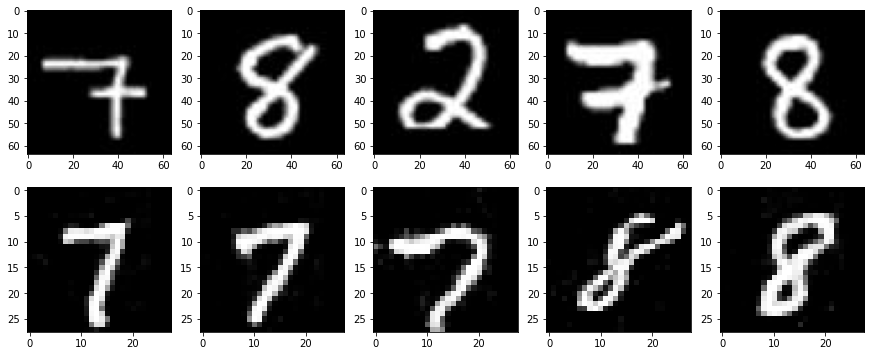

In [229]:
# 생성 화상과 훈련 화상을 시각화한다
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 입력 난수 생성
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
G_update.eval()
fake_images = G_update(fixed_z.to(device))

# 훈련 데이터
batch_iterator = iter(test_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다


# 출력
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 상단에 훈련 데이터를,
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 하단에 생성 데이터를 표시한다
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')